In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('../../pycore/')
from simulate import RBA_result
from utils import extract_details_from_rxnid

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
import matplotlib.lines as mlines
%matplotlib inline

In [2]:
df_prot = pd.read_excel('../../build_GAMS_model/input/PROTEIN_stoich_curation.xlsx')
df_prot.index = df_prot.id.to_list()

#### Simulation

In [3]:
df_path_sim = pd.read_excel('./manual_pathways_assignments.xlsx')

In [4]:
flistall = []

flist = ['vglc_0_5', 'vglc_1_0', 'vglc_2_0', 'vglc_3_0', 'vglc_4_0',
         'vglc_5_0', 'vglc_5_5']
flistall += flist
reslist = []
for fdir in flist:
    res = RBA_result(biom_id=None)
    res.load_from_json('../output/clim/results_capacitycorrected/' + fdir + '/RBA_result.json')
    reslist.append(res)
    
flist = ['vglc_5_6', 'vglc_5_7', 'vglc_6_0', 'vglc_7_0', 'vglc_8_0',
         'vglc_9_0', 'vglc_10_0', 'vglc_11_0', 'vglc_12_0', 'vglc_13_0',
         'vglc_14_0', 'vglc_15_0', 'vglc_16_0', 'vglc_17_0']
flistall += flist
for fdir in flist:
    res = RBA_result(biom_id=None)
    res.load_from_json('../output/batch/results_capacitycorrected/' + fdir + '/RBA_result.json')
    reslist.append(res)

In [5]:
N = len(reslist)
for i in range(0,N):
    res = reslist[i]
    resname = flistall[i]
    
    for j in df_path_sim.index:
        p = df_path_sim.protein[j]
        if p in res.proteome_allocation.keys():
            df_path_sim.loc[j, resname] = res.proteome_allocation[p]

#### Experimental

In [6]:
df_data_idx = pd.read_excel('./expmt_exflux_data.xlsx')

In [7]:
df_path_expmt_raw = pd.read_excel('./manual_pathways_assignments.xlsx')

In [8]:
expmt_data = dict()

for i in df_data_idx.index:
    # Load proteomics data
    i_exp = df_data_idx.data_id[i]
    df_data = pd.read_excel('../../parameterization/datasets/' + i_exp + \
                            '/' + i_exp + '.xlsx')
    df_data.index = df_data.id.to_list()
    
    # Conversion g/gDW -> g/gProtein. Conversion factor ptot = gProtein/gDW
    mu = df_data_idx.loc[i, 'GR_expmt (1/h)']
    ptot = (36.94 + 34.22*mu) / 100
    
    # Write to working dataframe
    df_path_expmt = df_path_expmt_raw.copy(deep=True)
    for j in df_path_expmt.index:
        p = df_path_expmt.protein[j]
        if p in df_data.index:
            gpgDW = df_data.loc[p, 'conc (g/gDW)']
            df_path_expmt.loc[j, 'conc (g/gProtein)'] = gpgDW / ptot
            
    expmt_data[i_exp] = df_path_expmt

In [16]:
df_path_sim.loc[4,:]

pathway      Glycolysis/PPP
rxn_id                PGI_c
protein             YBR196C
vglc_0_5           0.000029
vglc_1_0           0.000051
vglc_2_0           0.000089
vglc_3_0           0.000136
vglc_4_0           0.000153
vglc_5_0           0.000196
vglc_5_5           0.000195
vglc_5_6           0.000247
vglc_5_7           0.000253
vglc_6_0            0.00027
vglc_7_0           0.000326
vglc_8_0           0.000383
vglc_9_0           0.000439
vglc_10_0          0.000496
vglc_11_0          0.000552
vglc_12_0          0.000608
vglc_13_0          0.000665
vglc_14_0          0.000721
vglc_15_0          0.000778
vglc_16_0          0.000834
vglc_17_0           0.00089
Name: 4, dtype: object

#### Plot

In [9]:
pw = 'Glycolysis/PPP'

# Simulated
df = df_path_sim[df_path_sim.pathway == pw]
N = len(reslist)
x_sim, y_sim = [],[]
for i in range(0,N):
    res = reslist[i]
    x_sim.append(-res.metabolic_flux['EX_glc__D_e'])
    
    resname = flistall[i]
    y_sim.append(df[resname].fillna(0).sum())

# Experimental
x_exp, y_exp = [],[]
for i in df_data_idx.index:
    x_exp.append(df_data_idx.loc[i, 'Glucose uptake rate (mmol/gDW/h)'])
    
    expname = df_data_idx.data_id[i]
    df = expmt_data[expname]
    df = df[df.pathway == pw]
    y_exp.append(df['conc (g/gProtein)'].fillna(0).sum())

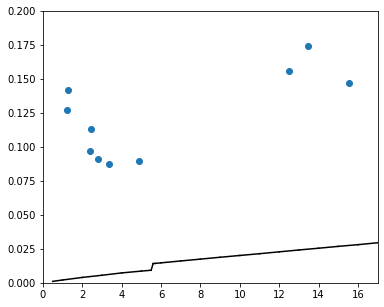

In [13]:
fig,ax = plt.subplots(figsize=(6,5))

# Plot model-predicted protein capacity usage
N = len(x_sim)
for i in range(0,N-1):
    p1 = [x_sim[i], x_sim[i+1]]; p2 = [y_sim[i], y_sim[i+1]]
    line = mlines.Line2D(p1, p2, color='k', linestyle='-')
    ax.add_line(line);
    
# Plot experimental protein capacity usage
ax.scatter(x_exp, y_exp)

ax.set_ylim(0,0.2);
ax.set_xlim(0,17);

In [39]:
expmt_data['Bjorkeroth2020_batchYNB']

,pathway,rxn_id,protein,conc (g/gProtein)
0,Glycolysis/PPP,HEX1_c,YCL040W,0.000033
1,Glycolysis/PPP,HEX1_c,YFR053C,0.000023
2,Glycolysis/PPP,HEX1_c,YGL253W,0.000698
3,Glycolysis/PPP,HEX1_c,YLR446W,NaN
4,Glycolysis/PPP,PGI_c,YBR196C,0.002071
...,...,...,...,...
67,TCA/Energy,SUCDq6_m,YKL141W,0.000007
68,TCA/Energy,SUCDq6_m,YKL148C,0.000019
69,TCA/Energy,SUCDq6_m,YLL041C,0.000113
70,TCA/Energy,FUM_m,YPL262W_m,0.000224


In [37]:
expmt_data['Elsemman2022_batchGlc']

,pathway,rxn_id,protein,conc (g/gProtein)
0,Glycolysis/PPP,HEX1_c,YCL040W,NaN
1,Glycolysis/PPP,HEX1_c,YFR053C,6.964399e-07
2,Glycolysis/PPP,HEX1_c,YGL253W,6.569043e-04
3,Glycolysis/PPP,HEX1_c,YLR446W,NaN
4,Glycolysis/PPP,PGI_c,YBR196C,1.243278e-03
...,...,...,...,...
67,TCA/Energy,SUCDq6_m,YKL141W,1.025103e-05
68,TCA/Energy,SUCDq6_m,YKL148C,2.129591e-05
69,TCA/Energy,SUCDq6_m,YLL041C,1.025103e-05
70,TCA/Energy,FUM_m,YPL262W_m,8.058651e-05


In [7]:
df_path

,pathway,rxn_id,protein,vglc_0_5,vglc_1_0,vglc_2_0,vglc_3_0,vglc_4_0,vglc_5_0,vglc_5_5,...,vglc_8_0,vglc_9_0,vglc_10_0,vglc_11_0,vglc_12_0,vglc_13_0,vglc_14_0,vglc_15_0,vglc_16_0,vglc_17_0
0,Glycolysis/PPP,HEX1_c,YCL040W,0.000047,0.000090,0.000168,0.000237,0.000297,0.000351,0.000379,...,0.000050,0.000011,0.000065,0.000147,0.000131,0.000126,0.000188,0.000194,0.000214,0.000228
1,Glycolysis/PPP,HEX1_c,YFR053C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Glycolysis/PPP,HEX1_c,YGL253W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000056,0.000093,NaN,0.000014,NaN,NaN
3,Glycolysis/PPP,HEX1_c,YLR446W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000186,0.000116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Glycolysis/PPP,PGI_c,YBR196C,0.000029,0.000051,0.000089,0.000136,0.000153,0.000196,0.000195,...,0.000383,0.000439,0.000496,0.000552,0.000608,0.000665,0.000721,0.000778,0.000834,0.000890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,TCA/Energy,SUCDq6_m,YKL141W,0.000001,0.000003,0.000005,0.000007,0.000008,0.000009,0.000010,...,0.000009,0.000008,0.000008,0.000008,0.000007,0.000007,0.000006,0.000006,0.000006,0.000005
68,TCA/Energy,SUCDq6_m,YKL148C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,TCA/Energy,SUCDq6_m,YLL041C,0.000002,0.000004,0.000007,0.000009,0.000011,0.000013,0.000014,...,0.000012,0.000012,0.000011,0.000011,0.000010,0.000010,0.000009,0.000009,0.000008,0.000008
70,TCA/Energy,FUM_m,YPL262W_m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
res

In [3]:
df_path

,pathway,rxn_id,protein
0,Glycolysis/PPP,HEX1_c,YCL040W
1,Glycolysis/PPP,HEX1_c,YFR053C
2,Glycolysis/PPP,HEX1_c,YGL253W
3,Glycolysis/PPP,HEX1_c,YLR446W
4,Glycolysis/PPP,PGI_c,YBR196C
...,...,...,...
67,TCA/Energy,SUCDq6_m,YKL141W
68,TCA/Energy,SUCDq6_m,YKL148C
69,TCA/Energy,SUCDq6_m,YLL041C
70,TCA/Energy,FUM_m,YPL262W_m
